In [31]:
import torch
import triton
from torch.utils.cpp_extension import load

BLOCK_SIZE = 32
device = torch.device("cuda")

cuda_module = load(
    name="smem_matmul",
    extra_include_paths=["cuda"],
    sources=["cuda/smem_cuda_matmul.cpp", "cuda/smem_cuda_matmul.cu"])

In [32]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    cuda_module.torch_launch_smem_cuda_matmul(out, a, b, M, N, K, a.stride(0),
                                              a.stride(1), b.stride(0),
                                              b.stride(1), out.stride(0),
                                              out.stride(1), BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [33]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    assert torch.allclose(torch.matmul(a, b), matmul(a, b), atol=5e-4), (size, a[0][0].item(), b[0][0].item())

In [34]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['cuda', 'torch'],
                             line_names=[
                                 "CUDA",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="smem-cuda-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'cuda':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

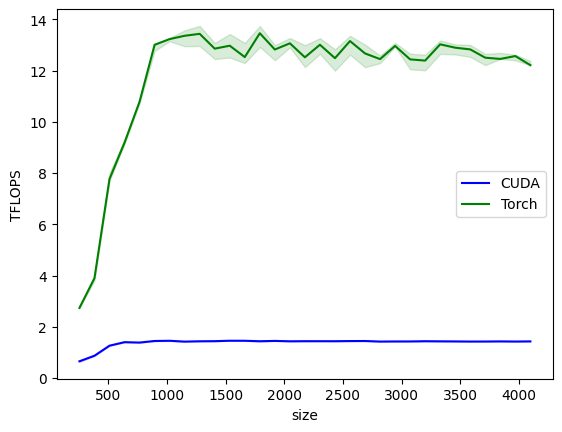

smem-cuda-matmul-perf:
      size      CUDA      Torch
0    256.0  0.655360   2.737796
1    384.0  0.871446   3.901813
2    512.0  1.263916   7.770828
3    640.0  1.401300   9.189008
4    768.0  1.385715  10.789464
5    896.0  1.447913  13.008593
6   1024.0  1.455345  13.231243
7   1152.0  1.423242  13.360107
8   1280.0  1.436240  13.436392
9   1408.0  1.440453  12.857962
10  1536.0  1.456974  12.972818
11  1664.0  1.455664  12.528668
12  1792.0  1.437927  13.459884
13  1920.0  1.450297  12.823748
14  2048.0  1.434931  13.066368
15  2176.0  1.439629  12.520790
16  2304.0  1.439012  13.010380
17  2432.0  1.438724  12.486429
18  2560.0  1.444453  13.154226
19  2688.0  1.446391  12.671411
20  2816.0  1.425059  12.449642
21  2944.0  1.429176  12.964629
22  3072.0  1.429975  12.439427
23  3200.0  1.438444  12.391918
24  3328.0  1.434091  13.026194
25  3456.0  1.430500  12.895324
26  3584.0  1.425599  12.828334
27  3712.0  1.426942  12.504802
28  3840.0  1.431723  12.456552
29  3968.0  1.425

In [35]:
benchmark.run(show_plots=True, print_data=True)

In [36]:
torch.cuda.empty_cache()